In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

## Read the Data

In [4]:
data = "./data/data_for_student_case.csv"
df1 = pd.read_csv(data)

FileNotFoundError: [Errno 2] File ./Part 1/data/data_for_student_case.csv does not exist: './Part 1/data/data_for_student_case.csv'

## Number of Transactions

In [3]:
print("Number of rows = " + str(len(df1.index)))
print("Number of fradulent transactions = " + str(len(df1.loc[df1['simple_journal'] == 'Chargeback'])))
print("Number of valid transactions = " + str(len(df1.loc[df1['simple_journal'] == 'Settled'])))  

Number of rows = 290382
Number of fradulent transactions = 345
Number of valid transactions = 236691


## Sample Data

In [4]:
df1.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


## Data Preprocessing

In [5]:
#Prepare class label, card id, ip id and date for plotting
# 1.Class label 
df1 = df1.loc[~(df1['simple_journal'] == 'Refused')]
df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0

# 2.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 3.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)

# 4. Date
df1['creationdate'] = pd.to_datetime(df1['creationdate'])
df1['date'] = df1['creationdate'].dt.date

## Fradulent transactions per card id

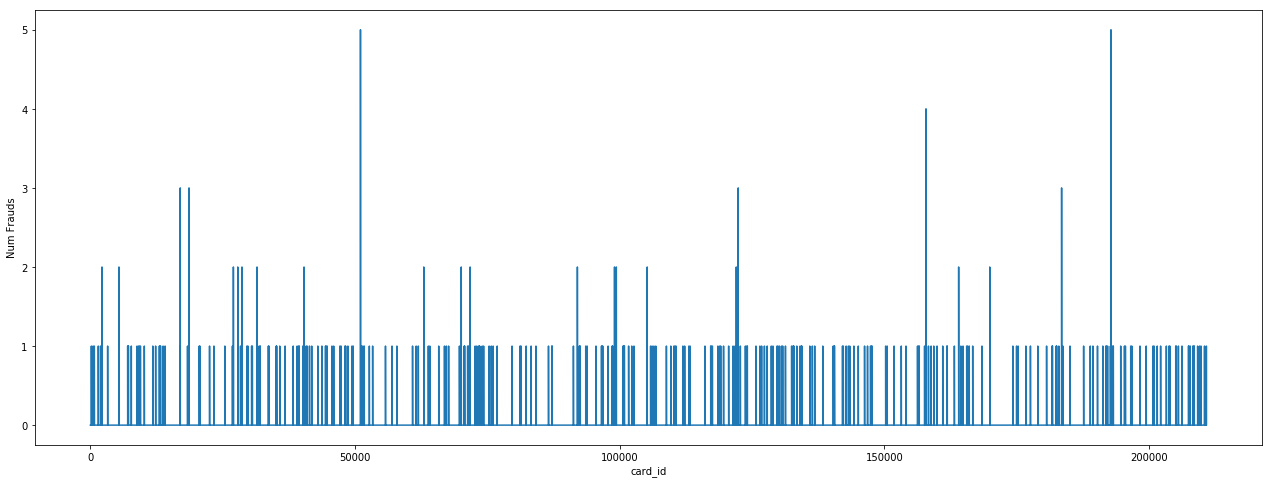

In [6]:
df2 = df1[['card_id','simple_journal']].groupby(['card_id']).sum()
len(df2.loc[df2['simple_journal'] > 0])
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df2.index,y=df2['simple_journal'])
ax.set(ylabel = "Num Frauds")
plt.show()

## Fradulent transactions per IP

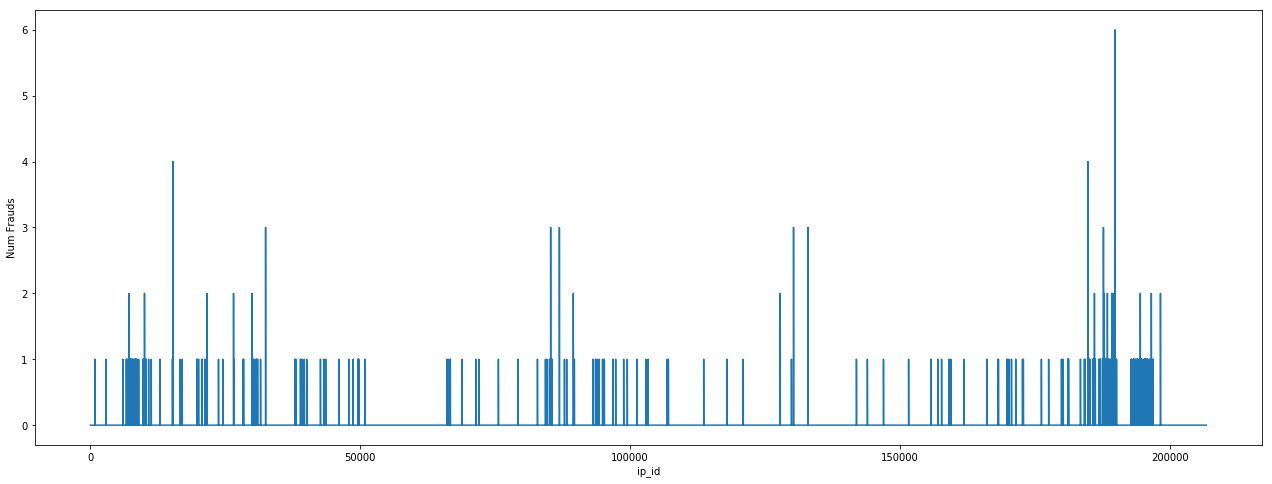

In [66]:
df3 = df1[['ip_id','simple_journal']].groupby(['ip_id']).sum()
len(df3.loc[df3['simple_journal'] > 0])
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df3.index,y=df3['simple_journal'])
ax.set(ylabel = "Num Frauds")
plt.show()

## Frandulent transactions per day

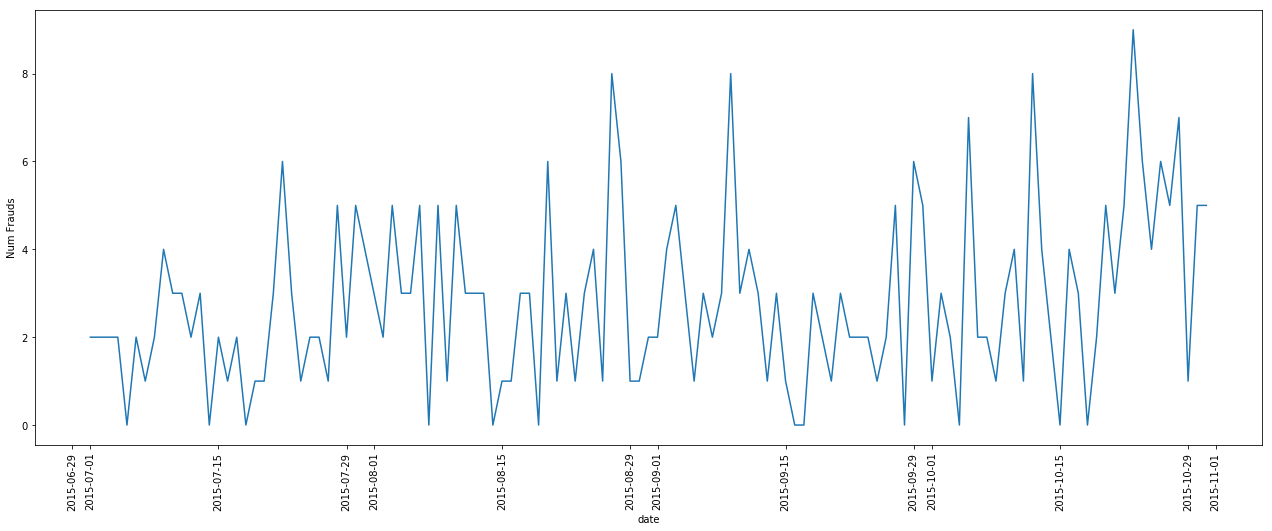

In [68]:
df4 = df1[['date','simple_journal']].groupby(['date']).sum()
len(df4.loc[df4['simple_journal'] > 0])
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df4.index,y=df4['simple_journal'])
ax.set(ylabel = "Num Frauds")
# ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.xticks(rotation=90)
plt.show()

## Data Preprocessing

In [57]:
#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)


enc1 = LabelEncoder()
enc1.fit(df1['txvariantcode'])
df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df1['currencycode'])
df1['currencycode'] = enc2.transform(df1.currencycode)

enc3 = LabelEncoder()
enc3.fit(df1['shopperinteraction'])
df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df1['accountcode'])
df1['accountcode'] = enc4.transform(df1.accountcode)

enc5 = LabelEncoder()
enc5.fit(df1['cardverificationcodesupplied'])
df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df1['mail_id'])
df1['mail_id'] = enc6.transform(df1.mail_id)

df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

df1['day_of_week'] = df1['creationdate'].dt.dayofweek

df1['hour'] = df1['creationdate'].dt.hour


X = df1[['issuercountrycode','txvariantcode','bin','amount','currencycode','shoppercountrycode','shopperinteraction','cardverificationcodesupplied','cvcresponsecode','accountcode','mail_id','ip_id','card_id','amount_eur','countries_equal','day_of_week','hour']]


## Heat Maps

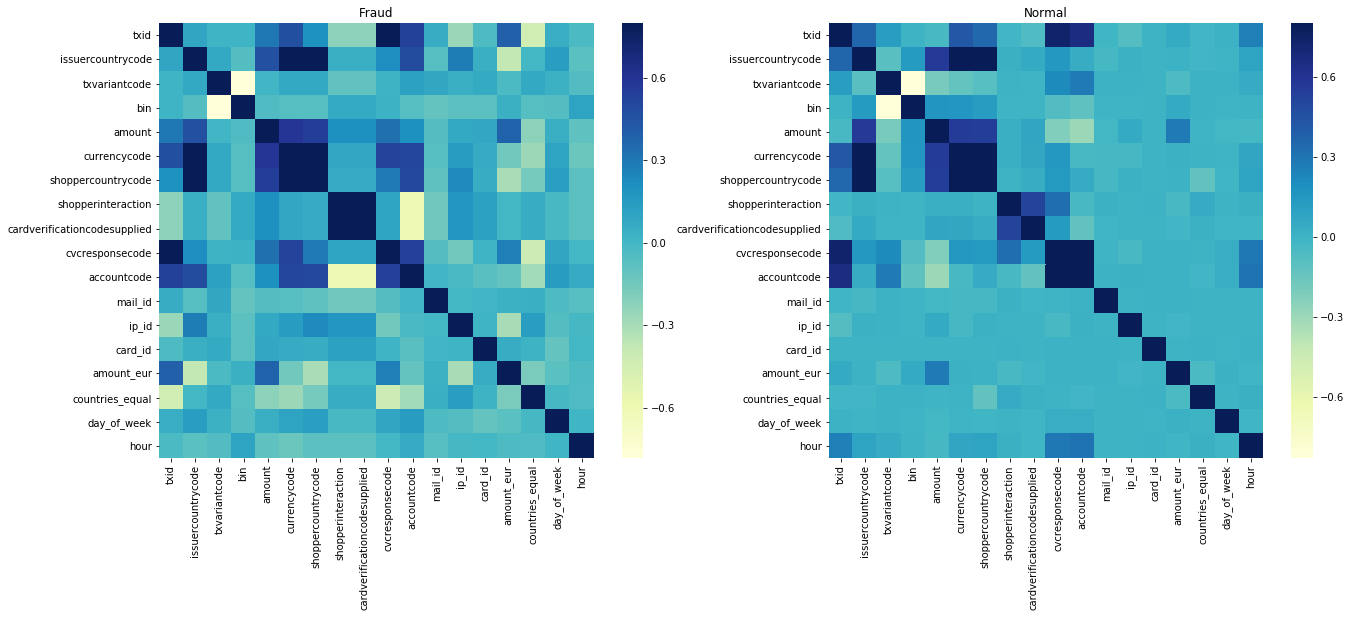

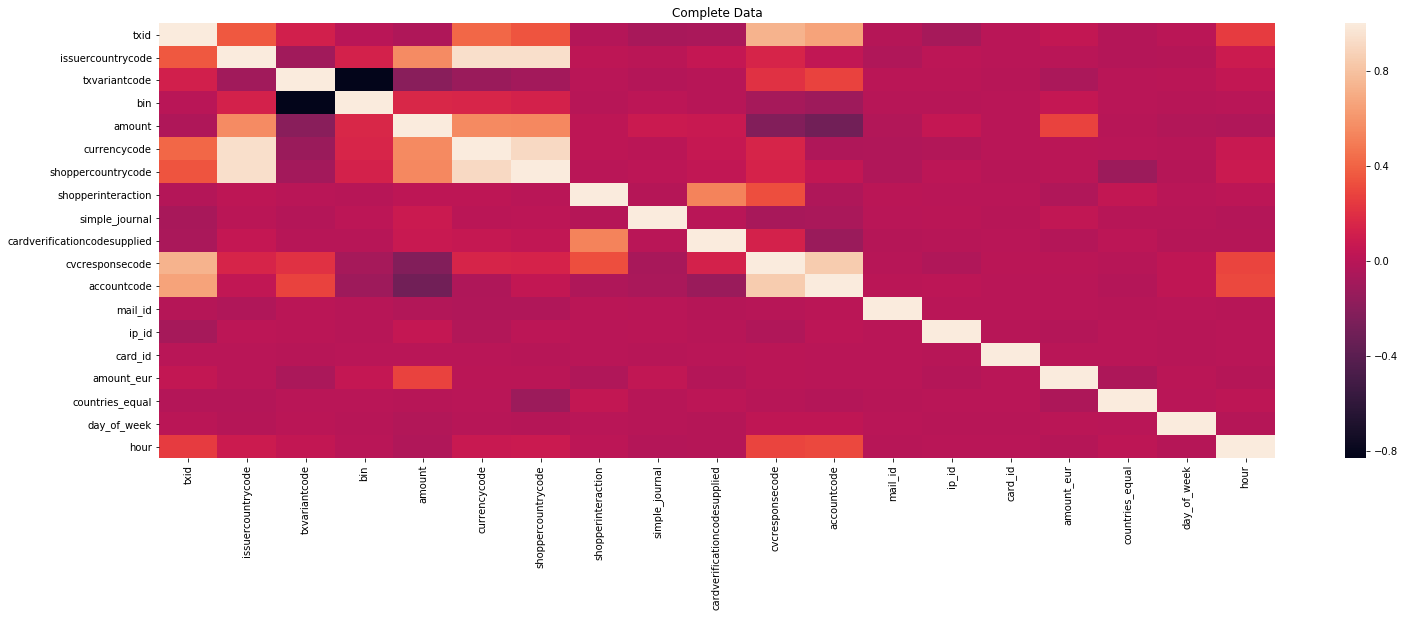

In [64]:
#correlation matrices
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.heatmap(df1.query('simple_journal==1').drop('simple_journal',1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(df1.query('simple_journal==0').drop('simple_journal',1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

f, (ax1) = plt.subplots(1,figsize =(25, 8))
sns.heatmap(df1.corr())
ax1.set_title('Complete Data')
plt.show()

